In [1]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-01-15 15:17:11.219366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 15:17:23.224675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-15 15:18:05.900049: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2024-01-15 15:18:05.903552: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:1: failed initializing StreamExecutor for CUDA device ordinal 1: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ER

In [4]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [5]:
dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_train = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [6]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

2024-01-15 15:18:07.889672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [1632]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [7]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

2024-01-15 15:18:08.587356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2880]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [8]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
    "GABOR_KERNEL_SIZE": 31,
    # "N_SCALES": 4,
    # "N_ORIENTATIONS": 16,
    "N_GABORS": 128,
    "INIT_JH": True,
    "A_GABOR": True,
    "A_GDNSPATIOFREQORIENT": True,
}
config = ConfigDict(config)
config

A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_GABORS: 128
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [9]:
wandb.init(project="PerceptNet_v15",
           name="V19_128GaborFree_A_DN_OG",
           job_type="training",
           config=config,
           mode="online",
           )
config = config
config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_GABORS: 128
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [10]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [21]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDN(kernel_size=(1,1), apply_independently=False)(outputs)

        return outputs

## Define the metrics with `clu`

In [22]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [23]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [24]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [25]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [26]:
from functools import partial

In [27]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    if return_grads: return state, grads
    else: return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [28]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [29]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))

In [30]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))

In [31]:
import matplotlib.pyplot as plt

In [32]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

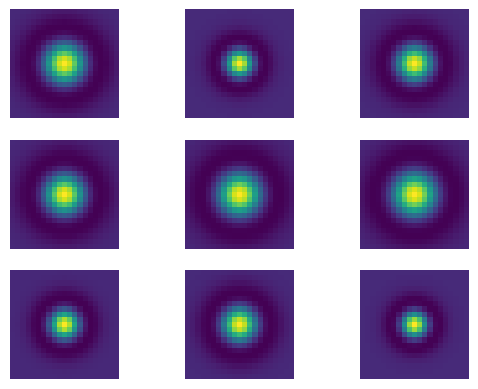

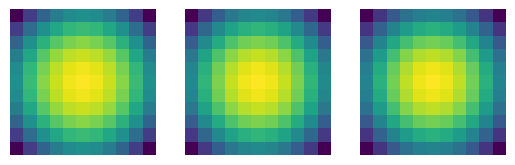

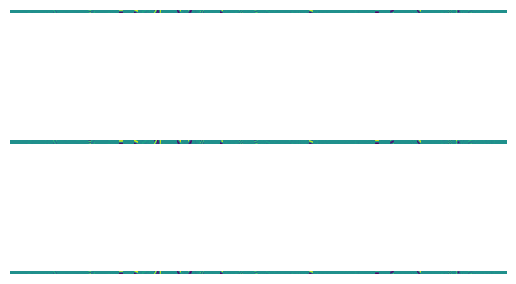

In [33]:
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

In [34]:
def check_trainable(path):
    # return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)
    if not config.A_GDNSPATIOFREQORIENT:
        return ("GDNSpatioFreqOrient_0" in path) and ("A" in path)
    return False

In [35]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDN_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    Conv_0: {
        kernel: 'trainable',
    },
    GDN_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'trainable',
        K: 'trainable',
        A: 'trainable',
    },
    GDNGaussian_0: {
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
            bias: 'trainable',
        },
    },
    GaborLayerGammaRepeat_0: {
        freq: 'trainable',
        gammax: 'trainable',
        gammay: 'trainable',
        theta: 'trainable',
        sigma_theta: 'trainable',
        phase: 'trainable',
        A: 'trainable',
    },
    GDN_2: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
})

In [36]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [37]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [38]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [39]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(17721, 17721)

In [40]:
wandb.run.summary["total_parameters"] = param_count
wandb.run.summary["trainable_parameters"] = trainable_param_count

In [41]:
from perceptualtests.color_matrices import Mng2xyz, Mxyz2atd

In [42]:
inputs = jnp.ones(shape=(1,28,28,3))

In [43]:
inputs_atd = inputs @ Mng2xyz.T @ Mxyz2atd.T

In [44]:
Mng2xyz.T @ Mxyz2atd.T

array([[ 39.0454 ,  30.1207 ,  14.27948],
       [115.8404 , -63.3502 ,  41.26816],
       [ 16.3118 ,  30.2934 , -61.51888]])

In [47]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Opponent color channel transformation
if config.INIT_JH:
    state.params["Conv_0"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
                                                  [115.8404,-63.3502,41.26816],
                                                  [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.01,1.01,
                                                            1.01,1.1,1.01,
                                                            1.01,1.01,1.1])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"])*0.1

# ## DN End
state.params["GDN_2"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_2"]["Conv_0"]["bias"])*0.1
state.params["GDN_2"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_2"]["Conv_0"]["kernel"])*0.5

state = state.replace(params=freeze(state.params))

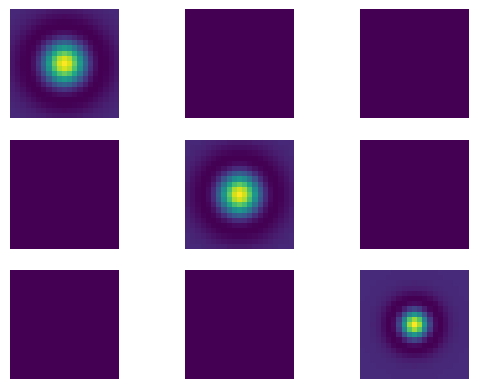

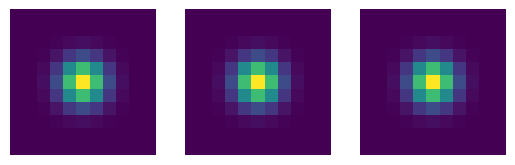

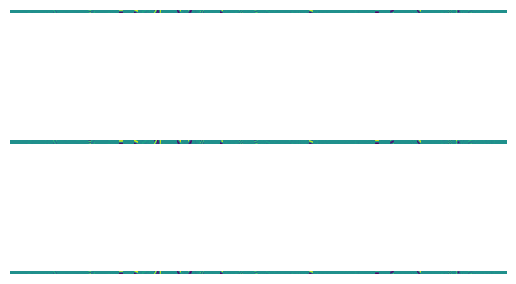

In [48]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [49]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [50]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [51]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

2024-01-15 15:21:33.425446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [1632]
	 [[{{node Placeholder/_2}}]]


In [52]:
from functools import partial

In [53]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [54]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [55]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 3min 30s, sys: 6.85 s, total: 3min 37s
Wall time: 4.15 s


(64, 96, 128, 128)

In [56]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 33min 17s, sys: 1min 16s, total: 34min 34s
Wall time: 48.7 s


In [57]:
# jax.config.update("jax_debug_nans", True)

In [58]:
def filter_extra(extra):
    def filter_intermediates(path, x):
        path = "/".join(path)
        if "Gabor" in path:
            return (x[0][0],)
        else: 
            return x
    extra = unfreeze(extra)
    extra["intermediates"] = flax.traverse_util.path_aware_map(filter_intermediates, extra["intermediates"])
    return freeze(extra)

In [49]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_param(state.params, "A", a_min=0))
        state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])
    extra = filter_extra(extra) ## Needed because the Gabor layer has multiple outputs
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

2024-01-10 13:00:28.682581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2880]
	 [[{{node Placeholder/_2}}]]


Epoch 0 -> [Train] Loss: -0.43439075350761414 [Val] Loss: -0.5657873153686523


KeyboardInterrupt: 

Save the final model as well in case we want to keep training from it or whatever:

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerLogSigma__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [ ]:
kernel = state.state["precalc_filter"]["GaborLayerLogSigma_0"]["kernel"]
kernel.shape

In [ ]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

In [ ]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()